In [2]:
import time, os

# Numpy
import numpy as np
import scipy
import sklearn
import pandas as pd

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense,\
                                    Activation, ZeroPadding2D,\
                                    BatchNormalization, Flatten, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D,\
                                    Dropout, GlobalMaxPooling2D,\
                                    GlobalAveragePooling2D

from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend

# To generate GIFs


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from datetime import datetime

from tqdm.notebook import tqdm

import IPython
from IPython import display
import ipywidgets as widgets


import ngraph_bridge

# For loading and making use of HE Transformer
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.python.tools import freeze_graph
import json


from skimage.color import rgb2lab, lab2rgb, rgb2gray
from PIL import Image
from skimage.transform import resize

In [3]:
def create_dataset():
    images = []
    new_shape = (256, 256, 3)
    for img in tqdm(glob.glob("stanford/cars_train/*.jpg")):
        t = np.asarray(Image.open(img)) # Open the image as numpy array
        if len(t.shape) == 3: # If it has not a third dimension we do not want it.
            t = resize(t, new_shape, anti_aliasing=True) # We resize it to a new_shape
            assert t.shape == new_shape
            images.append(t)
    images = np.array(images)
    np.save("stanford_cars_256.npy", images.astype('float32')) # Transformed to float32
    
create_dataset()

In [9]:
def transform_dataset(X, shape):
    lst = []
    for i in tqdm(range(X.shape[0])):
        lst.append(resize(X[i], shape, anti_aliasing=True))
    return np.array(lst)

def load_dataset(shape=(128, 128, 3)):
    X = np.load("stanford_cars_128.npy")
    if shape != X[0].shape:
        X = transform_dataset(X, shape)
    return X


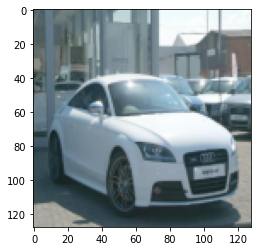

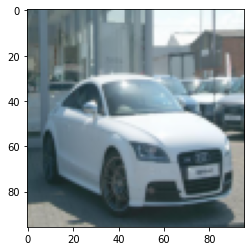

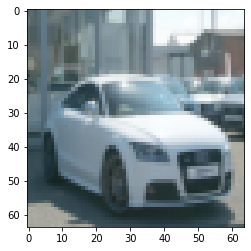

In [8]:
items = load_dataset((128, 128, 3))
np.save('stanford_cars_128.npy', items)
plot_color_img(items[0])
items = load_dataset((96, 96, 3))
np.save('stanford_cars_96.npy', items)
plot_color_img(items[0])
items = load_dataset((64, 64, 3))
np.save('stanford_cars_64.npy', items)
plot_color_img(items[0])

### Auxiliary code for creating and extracting the dataset

In [263]:
def plot_grayscale_img(img):
    plt.imshow(img[...,0], cmap='gray')
    plt.show()

def plot_color_img(img):
    plt.imshow(img)
    plt.show()


def create_dir(dirname):
    try:
        # Create target Directory
        os.mkdir(dirname)
        #print("dirname " , filename ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirname ,  " already exists")

create_dir('models')

def plot_20_images(x, save = False, savefile="img.png"):
    w=10
    h=10
    fig=plt.figure(figsize=(w, h))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i - 1, :, :])
    if save:
        plt.savefig(savefile)
    plt.show()
    plt.close()

def plot_20_gray(x, save = False, savefile="img.png"):
    w=10
    h=10
    fig=plt.figure(figsize=(w, h))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i - 1, :, :], cmap='gray')
    if save:
        plt.savefig(savefile)
    plt.show()
    plt.close()


def plot_3(original, gray, colored):
    display.clear_output(wait=True)
    w=10
    h=10
    fig=plt.figure(figsize=(w, h))
    columns = 3
    rows = 1
    
    fig.add_subplot(rows, columns, 1)
    plt.imshow(original)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(gray)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(colored)
    plt.show()
    plt.close()

def make_gif(anim_file, file_regex):
    #anim_file = 'dcgan.gif'
    fname = None
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(file_regex)
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.75)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)


Directory  models  already exists


### Code from Intel nGraph Examples
The code below is used to extract the computation graph out of the session of Keras or Tensorflow 

In [ ]:
def print_nodes(graph_def=None):
    """Prints the node names of a graph_def.
        If graph_def is not provided, use default graph_def"""

    if graph_def is None:
        nodes = [n.name for n in tf.get_default_graph().as_graph_def().node]
    else:
        nodes = [n.name for n in graph_def.node]

    print("nodes", nodes)

# https://www.dlology.com/blog/how-to-convert-trained-keras-model-to-tensorflow-and-make-prediction/
def freeze_session(session,
                   keep_var_names=None,
                   output_names=None,
                   clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import (
        convert_variables_to_constants,
        remove_training_nodes,
    )

    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(
            set(v.op.name for v in tf.global_variables()).difference(
                keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        print_nodes(input_graph_def)
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        frozen_graph = remove_training_nodes(frozen_graph)
        return frozen_graph

def save_model(sess, output_names, directory, filename):
    frozen_graph = freeze_session(sess, output_names=output_names)
    print_nodes(frozen_graph)
    tf.io.write_graph(frozen_graph, directory, filename + ".pb", as_text=False)
    print("Model saved to: %s" % filename + ".pb")

    
def load_pb_file(filename):
    """"Returns the graph_def from a saved protobuf file"""
    if not os.path.isfile(filename):
        raise Exception("File, " + filename + " does not exist")

    with tf.io.gfile.GFile(filename, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())

    print("Model restored")
    return graph_def

## Loading the dataset

(7313, 64, 64, 3) (813, 64, 64, 3)


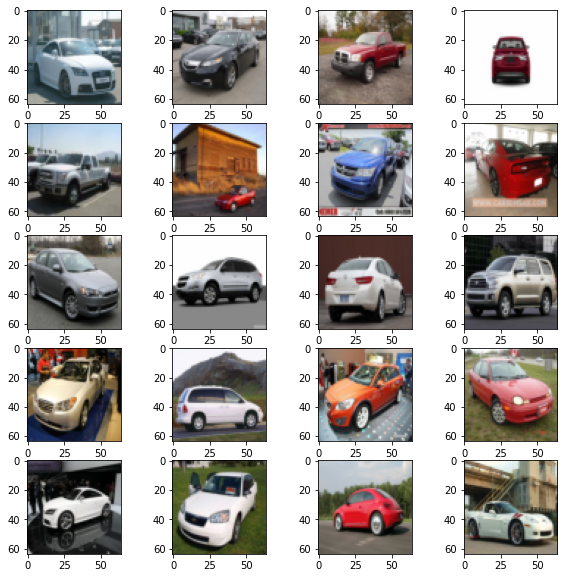

(7313, 64, 64) (813, 64, 64)


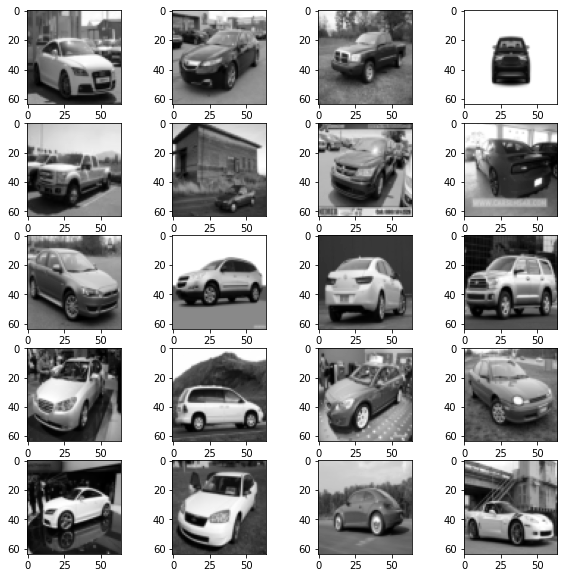

In [238]:
items = np.load('stanford_cars_64.npy')
train_test = int(len(items) * 0.90)
items, items_test = items[:train_test], items[train_test:]
print(items.shape, items_test.shape)
plot_20_images(items)
items_gray = np.dot(items, [0.2989, 0.5870, 0.1140])
items_gray_test = np.dot(items_test, [0.2989, 0.5870, 0.1140])
print(items_gray.shape, items_gray_test.shape)
plot_20_gray(items_gray)

In [318]:
%%time 
def get_dataset_lab():
    items = np.load('stanford_cars_128.npy')
    items = rgb2lab(items)
    train_test = int(len(items) * 0.90)
    items = (items + [0, 128, 128]) / [100, 255, 255]
    items, items_test = items[:train_test], items[train_test:]
    print(items.shape, items_test.shape)
    return items, items_test
items, items_test = get_dataset_lab()

(7313, 128, 128, 3) (813, 128, 128, 3)
CPU times: user 34.2 s, sys: 17.5 s, total: 51.7 s
Wall time: 51.7 s


In [319]:
items.shape, items_test.shape

((7313, 128, 128, 3), (813, 128, 128, 3))

In [259]:
a = items[0]


(64, 64, 1)

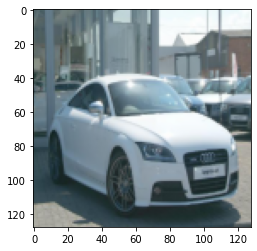

(128, 128, 3)


In [320]:
def to_gray(rgb):
    t = np.dot(rgb, [0.2989, 0.5870, 0.1140])
    t = np.expand_dims(t, -1)
    return t

def lab_split(lab):
    l = lab[..., 0]
    a = lab[..., 1]
    b = lab[..., 2]
    return l, a, b

def lab_join(l, a, b):
    lab = np.zeros(l.shape + (3,))
    lab[..., 0] = l 
    lab[..., 1] = a 
    lab[..., 2] = b
    return lab 

def to_rgb(lab):
    l, a, b = lab_split(lab)
    
    lab_scaled = np.zeros(lab.shape)
    lab_scaled[..., 0] = (l * 100)
    lab_scaled[..., 1] = (a * 255) - 128
    lab_scaled[..., 2] = (b * 255) - 128
    return lab2rgb(lab_scaled)

#print(to_gray(items[0]).shape)
plot_color_img(to_rgb(items[0]))
print(items[0].shape)

In [328]:
l, a, b = lab_split(items[2])
l.shape, a.shape, b.shape

((128, 128), (128, 128), (128, 128))

In [329]:
lab = lab_join(l, a, b)
lab.shape

(128, 128, 3)

## Model
The cell below includes the cryptonets model. It is composed of the following:
1. A convolutional layer , with 5 filters of size 5x5, same padding and stride 2. $n^{[l]} = \dfrac{(n^{[l-1]} + 2 * p^{[l]} - f^{[l]})}{s^{[l]}} + 1$.
 - Input: 28 x 28 x 1
 - Output: 14 x 14 x 5
2. A square activation function $g(x) = x^2$
3. An average pooling layer with 1 stride and same padding. $n^{[l]} = \dfrac{(n^{[l-1]} - f^{[l]})}{s^{[l]}} + 1$.
 - Input: 14 x 14 x 5
 - Output: 14 x 14 x5
4. Another convolutional layer , with 50 filters of size 5x5, same padding and stride 2. $n^{[l]} = \dfrac{(n^{[l-1]} + 2 * p^{[l]} - f^{[l]})}{s^{[l]}} + 1$.
 - Input: 14 x 14 x 5
 - Output: 7 x 7 x 50
5. Another average pooling layer.
 - Input: 7 x 7 x 50
 - Output: 7 x 7 x 50
6. A flattening layer, thus resulting in 7 x 7 x 50 = 2450 input attributes to the dense layer
7. A dense layer whose output is 100 from 2450
8. Another square activation layer
9. A final dense layer without any activation after it.

In [ ]:
def image_coloring():

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (20, 20), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1], name='input'))
    model.add(layers.ReLU())
    model.add(layers.Conv2D(64, (15, 15), strides=(2, 2), padding='same'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Conv2D(128, (10, 10), strides=(2, 2), padding='same'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(2, (2, 2), strides=(2, 2), 
                                     padding='same', activation='tanh', 
                                     name='output'))
    model.compile(loss='mse', 
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [367]:
def image_coloring_v2():
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(128, 128, 1)))
    model.add(Conv2D(64, (10, 10), activation='relu', padding='same'))
    model.add(Conv2D(64, (10, 10), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (10, 10), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(2, (3, 3), activation='sigmoid', padding='same'))
    model.add(tf.keras.layers.UpSampling2D((2, 2)))
    model.compile(loss='mse', 
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

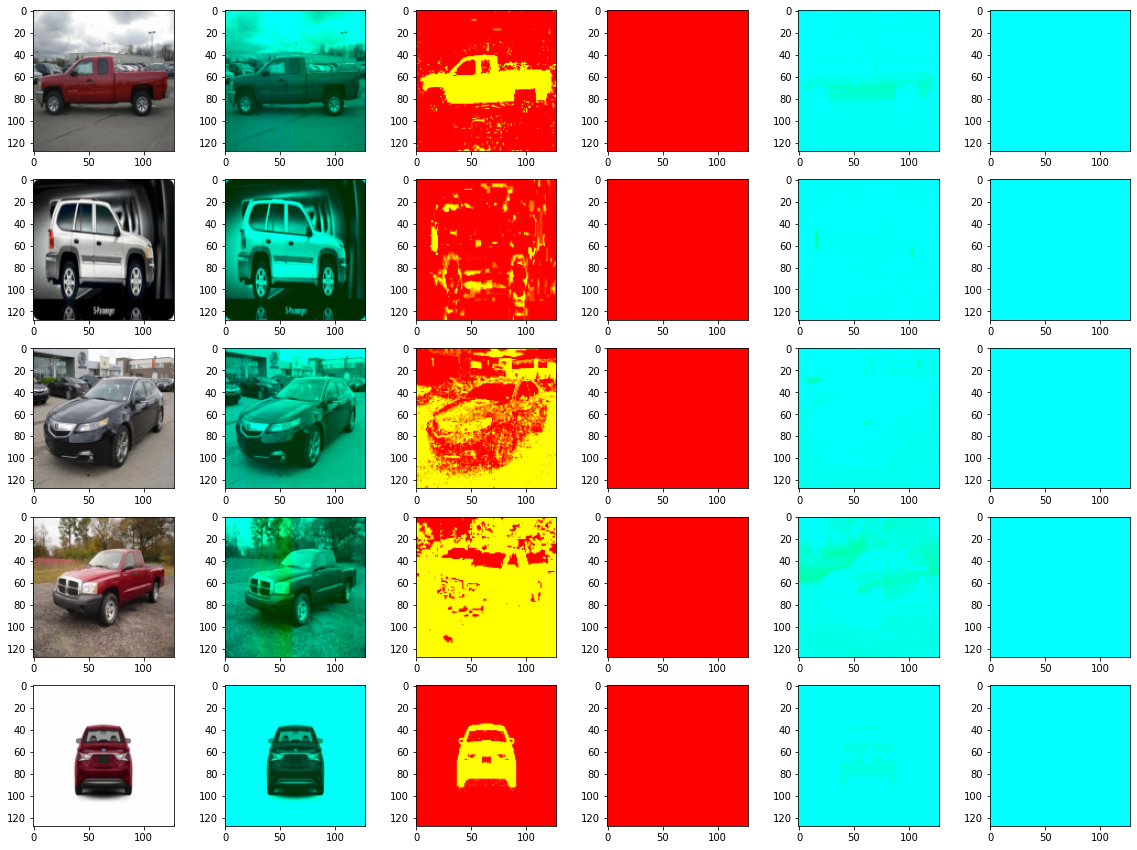

In [368]:
def colorize(model, img):
    gray = to_gray(img)
    colored = model.predict(gray.reshape(1, 64, 64,1))
    print(colored.shape)
    return img, gray, colored[0,...]

def show_guesses(nn, imgs):
    display.clear_output(wait=True)
    w=10
    h=15
    fig=plt.figure(figsize=(w, h))
    columns = 3
    rows = 5
    for i in range(1, columns*rows +1, 3):
        original, gray, colored = colorize(nn, imgs[i//3])
        fig.add_subplot(rows, columns, i)
        plt.imshow(original)
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(gray[...,0] , cmap='gray')
        fig.add_subplot(rows, columns, i + 2)
        plt.imshow(colored)  
    
    plt.show()
    plt.close()

def plotable_coord(a=None, b=None):
    if not a is None:
        lab = np.ones((128, 128, 3))
        lab[...,0] = np.ones((128, 128)) * 100
        lab[...,1] = a * 255 - 128
        lab[...,2] = np.zeros((128, 128)) * 255 - 128
        return lab
    if not b is None:
        lab = np.ones((128, 128, 3))
        lab[...,0] = np.ones((128, 128)) * 100
        lab[...,1] = np.zeros((128, 128)) * 255 - 128
        lab[...,2] = b * 255 - 128
        return lab2rgb(lab)   
    
def colorize_lab(nn, lab):
    l, a, b = lab_split(lab)
    ab = nn.predict(l.reshape(-1, 128, 128, 1))
    #b = model_b.predict(l.reshape(-1, 128, 128, 1))
    lab_hat = lab_join(l, ab[...,0], b[...,1])
    rgb_hat = to_rgb(lab_hat)
    rgb_y = to_rgb(lab)
    a_rgb = plotable_coord(a=a)
    a_hat_rgb = plotable_coord(a=ab[...,0])
    b_rgb = plotable_coord(b=b)
    b_hat_rgb = plotable_coord(b=ab[...,1])
    return rgb_y, rgb_hat, a_rgb, a_hat_rgb, b_rgb, b_hat_rgb
    
def show_lab_guesses(nn, lab_imgs):
    display.clear_output(wait=True)
    w=20
    h=15
    fig=plt.figure(figsize=(w, h))
    columns = 6
    rows = 5
    for i in range(1, columns*rows +1, columns):
        rgb_y, rgb_hat, a_rgb, a_hat_rgb, b_rgb, b_hat_rgb = colorize_lab(nn, lab_imgs[i//6])
        fig.add_subplot(rows, columns, i)
        plt.imshow(rgb_y)
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(rgb_hat)
        fig.add_subplot(rows, columns, i + 2)
        plt.imshow(a_rgb)  
        fig.add_subplot(rows, columns, i + 3)
        plt.imshow(a_hat_rgb)  
        fig.add_subplot(rows, columns, i + 4)
        plt.imshow(b_rgb)  
        fig.add_subplot(rows, columns, i + 5)
        plt.imshow(b_hat_rgb)  
    
    plt.show()
    plt.close()
show_lab_guesses(coloring_nn, imgs)

In [380]:
coloring_nn = image_coloring()
coloring_nn.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 64, 64, 32)        12832     
_________________________________________________________________
re_lu_100 (ReLU)             (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_294 (Conv2D)          (None, 32, 32, 64)        460864    
_________________________________________________________________
average_pooling2d_40 (Averag (None, 32, 32, 64)        0         
_________________________________________________________________
re_lu_101 (ReLU)             (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_295 (Conv2D)          (None, 16, 16, 128)       819328    
_________________________________________________________________
average_pooling2d_41 (Averag (None, 16, 16, 128)     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/skimage/c

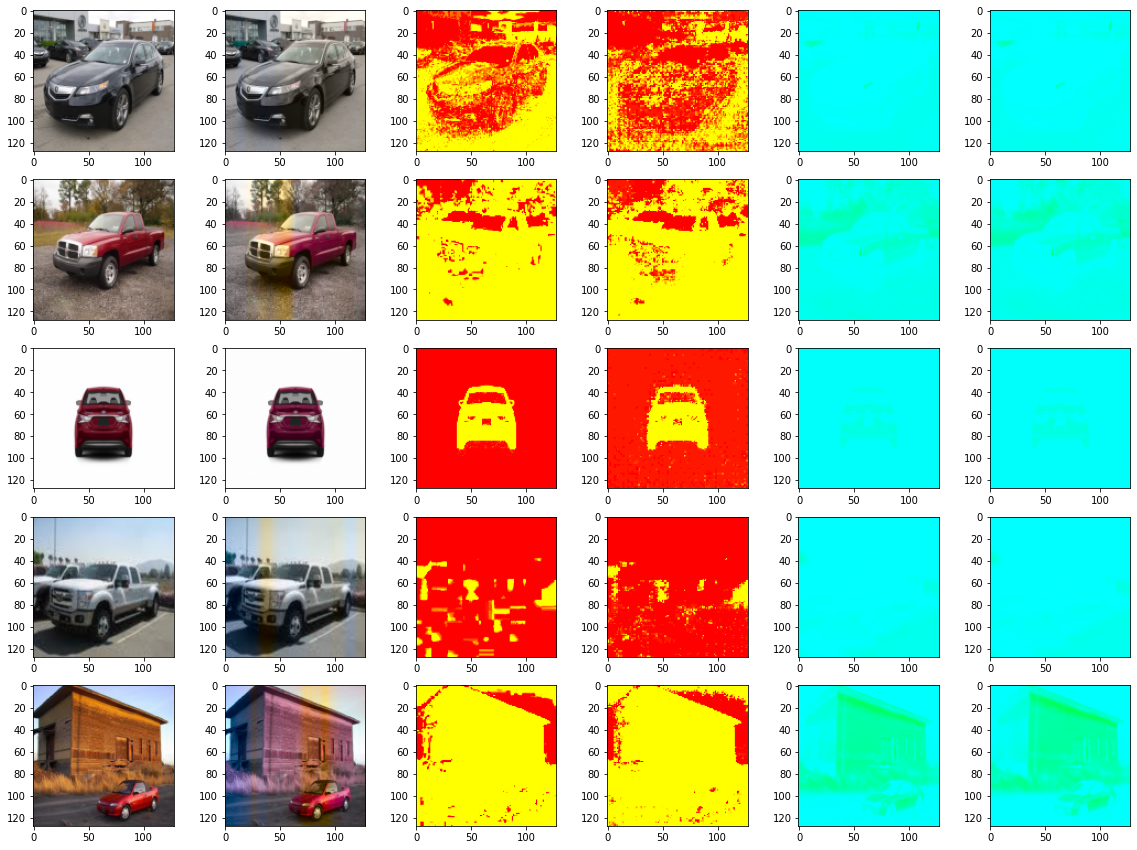

In [384]:
imgs = np.concatenate([items[[1, 2, 3, 4, 5]]])


coloring_nn.fit(x=items[1:10,:,:,0:1], y=items[1:10,:,:,1:], epochs=1000, verbose=1)
show_lab_guesses(coloring_nn, imgs)

## Creating a private model

In [ ]:
def image_coloring_private():
    def square_activation(x):
        return x * x 
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 1], name='input'))
    model.add(Activation(square_activation))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation(square_activation))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation(square_activation))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation(square_activation))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(Activation(square_activation))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation(square_activation))
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation(square_activation))
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation(square_activation))
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), 
                                     padding='same', activation='sigmoid', 
                                     name='output'))
    model.compile(loss='mse', 
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

### Creating the model
The model is created in a "tensorflow-like" way. We use the Keras layers to pass through them a placeholder input.

In [ ]:
x = Input(shape=(28, 28, 1), name="input")
y = cryptonets_model(x)
cryptonets_model = Model(inputs=x, outputs=y)
print(cryptonets_model.summary())

### Training the model
We first define the loss and the optimizer that we are going to make use of. 

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.categorical_crossentropy(labels, logits, from_logits=True)

optimizer = SGD(learning_rate=0.008, momentum=0.9)
cryptonets_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

Then, we train the model:

In [ ]:
cryptonets_model.fit(x_train, y_train, 
                     epochs=10, batch_size=64, 
                     validation_data=(x_test, y_test), 
                     verbose=1)

We save the model:

In [ ]:
cryptonets_model.save('models/cryptonets_model.h5')

In [ ]:
test_loss, test_acc = cryptonets_model.evaluate(x_test, y_test, verbose=1)

## Layer Squash
After having trained the model, we have the weights of the different layers. However, as you may have realised, we make use only of two activation functions in the whole model. The operations inbetween the matrix multiplications can be compressed into a single matrix. The objective of this operation is reducing the number of multiplications that we make on the resulting Neural Network, since it directly influences the noise in the Homomorphic Encryption domain.

This process is done specifically for each network model. The reason behind. It is hardly generalizable.

In order to extract the bias ($\vec{b}$) of that operation, the neural network is passed a vector of $0$. $W^T * x + \vec{b} = \vec{b}$ if $x = \vec{0}$

Once we have the bias ($\vec{b}$), we can extract the weights by multiplying by the identity matrix ($I$), and substracting the bias from the result. $W = W*I + b - b$

In [ ]:
# Squash linear layers and return squashed weights
def squash_layers(cryptonets_model, sess):
    # We get the different layers for the model
    layers = cryptonets_model.layers
    layer_names = [layer.name for layer in layers]
    conv1_weights = layers[layer_names.index('conv2d_1')].get_weights()
    conv2_weights = layers[layer_names.index('conv2d_2')].get_weights()
    fc1_weights = layers[layer_names.index('fc_1')].get_weights()
    fc2_weights = layers[layer_names.index('fc_2')].get_weights()

    # Get weight into the different layers
    y = Input(shape=(14 * 14 * 5,), name="squashed_input")
    y = Reshape((14, 14, 5))(y)
    y = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")(y)
    y = Conv2D(
        filters=50,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding="same",
        use_bias=True,
        trainable=False,
        kernel_initializer=tf.compat.v1.constant_initializer(conv2_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(conv2_weights[1]),
        name="conv2d_test",
    )(y)
    y = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")(y)
    y = Flatten()(y)
    y = Dense(
        100,
        use_bias=True,
        name="fc_1",
        kernel_initializer=tf.compat.v1.constant_initializer(fc1_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(fc1_weights[1]))(y)
    
    # We initialize the session global variables for the model.
    sess.run(tf.compat.v1.global_variables_initializer())

    # Pass 0 to get bias. If we multiply by 0, we get 0
    squashed_bias = y.eval(
        session=sess,
        feed_dict={
            "squashed_input:0": np.zeros((1, 14 * 14 * 5))
        })
    print(squashed_bias)
    
    # We execute the computation on the eye/identity matrix
    squashed_bias_plus_weights = y.eval(
        session=sess, feed_dict={
            "squashed_input:0": np.eye(14 * 14 * 5)
        })
    
    # If we subtract the bias, we can get the weights
    squashed_weights = squashed_bias_plus_weights - squashed_bias
    print(squashed_bias)
    print("squashed layers")

    # Sanity check - Checking that the variation on the result is not enormous
    x_in = np.random.rand(100, 14 * 14 * 5)
    network_out = y.eval(session=sess, feed_dict={"squashed_input:0": x_in})
    linear_out = x_in.dot(squashed_weights) + squashed_bias
    assert np.max(np.abs(linear_out - network_out)) < 1e-3

    return (conv1_weights, (squashed_weights, squashed_bias), fc1_weights,
            fc2_weights)

Finally, we define our new model, where we are making use of the different weights that we extracted before.

In [ ]:
def cryptonets_model_squashed(input, conv1_weights, squashed_weights,
                              fc2_weights):

    def square_activation(x):
        return x * x

    y = Conv2D(
        filters=5,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding="same",
        use_bias=True,
        kernel_initializer=tf.compat.v1.constant_initializer(conv1_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(conv1_weights[1]),
        input_shape=(28, 28, 1),
        trainable=False,
        name="convd1_1",
    )(input)
    y = Activation(square_activation)(y)

    # Using Keras model API with Flatten results in split ngraph at Flatten() or Reshape() op.
    # Use tf.reshape instead
    y = tf.reshape(y, [-1, 5 * 14 * 14])
    y = Dense(
        100,
        use_bias=True,
        name="squash_fc_1",
        trainable=False,
        kernel_initializer=tf.compat.v1.constant_initializer(
            squashed_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(squashed_weights[1]),
    )(y)
    y = Activation(square_activation)(y)

    y = Dense(
        10,
        use_bias=True,
        trainable=False,
        kernel_initializer=tf.compat.v1.constant_initializer(fc2_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(fc2_weights[1]),
        name="output",
    )(y)

    return y


In [ ]:
tf.reset_default_graph()
sess = tf.compat.v1.Session()
square_activation = lambda x: x * x 
cryptonets_model = tf.keras.models.load_model('models/cryptonets_model.h5', 
                                              custom_objects={'square_activation':square_activation,
                                                              'loss': loss})

In [ ]:
# Squash weights and save model
weights = squash_layers(cryptonets_model,
                        tf.compat.v1.keras.backend.get_session())
(conv1_weights, squashed_weights, fc1_weights, fc2_weights) = weights[0:4]


In [ ]:
# We reset the session and create the new model with the newly created weights
tf.reset_default_graph()
sess = tf.compat.v1.Session()

x = Input(shape=(28, 28, 1), name="input")
y = cryptonets_model_squashed(x, conv1_weights, squashed_weights, fc2_weights)
sess.run(tf.compat.v1.global_variables_initializer())
save_model(tf.compat.v1.keras.backend.get_session(), ["output/BiasAdd"], "./models", "cryptonets")

## Generating the Homorphic Encryption Configuration
We generate the parameters for the encryption. These parameteres usually set information about the Learning with Error (LWE) problem. The explanation of how to obtain the parameters is inline with the code. It is mainly extracted from the documentation of Intel nGraph HE Transformer Github Repository. After having executed this section code, a file 'config.json' has been generated with the configuration for the Neural Network.

In [ ]:
def get_N(total_coefficient_modulus_bit_width, security_level, sec_type='classical'):
    sec = {
        'classical':{
            128:{
                1024:  27,
                2048:  54,
                4096:  109,
                8192:  218,
                16384: 438,
                32768: 881
            },
            192:{
                1024:  19,
                2048:  37,
                4096:  75,
                8192:  152,
                16384: 305,
                32768: 611
            },
            256:{
                1024:  14,
                2048:  29,
                4096:  58,
                8192:  118,
                16384: 237,
                32768: 476
            }
        },
        'quantum':{
           128:{
                1024:  25,
                2048:  51,
                4096:  101,
                8192:  202,
                16384: 411,
                32768: 827
            },
            192:{
                1024:  17,
                2048:  35,
                4096:  70,
                8192:  141,
                16384: 284,
                32768: 571
            },
            256:{
                1024:  13,
                2048:  27,
                4096:  54,
                8192:  109,
                16384: 220,
                32768: 443
            }
        }
    }
    log2q_prev = 0
    for n, log2q in sec[sec_type][security_level].items():
        if log2q_prev < total_coefficient_modulus_bit_width < log2q:
            return n
        log2q_prev = log2q
    return n
def define_encryption_params(security_level, L):
    # Select the security level
    # Compute the multiplicative depth of the computational graph
    #L = 8 # Assumed from configuration
    # Estimate the bit-precission s, required. According to Intel, the best tradeoff is ~24 bits
    s = 24
    # Choose the coeff_modulus = [s, s, s, ..., s]. A list of L coefficient moduli, each with s bits. Set the scale to s.
    coeff_modulus = [s] * L
    coeff_modulus[0] = 30
    coeff_modulus[-1] = 30
    scale = s
    # Compute the total coefficient modulus bit width, L * s in the above parameter selection.
    total_coefficient_modulus_bit_width = L * s
    # Set the poly_modulus_degree to the smallest power of two, with coefficient modulus smaller than the maximum allowed.
    # Based on the table of recommended parameters. 
    N = get_N(total_coefficient_modulus_bit_width, security_level)
    poly_modulus_degree = N
    # For best performance, we should choose the batch_size to max_batch_size
    max_batch_size = poly_modulus_degree / 2
    # We should only include the complex packing if there are polynomial activations.
    # That is, if we make use of our own activation functions
    complex_packing = False
    
    enc_params = {
        'scheme_name': 'HE_SEAL',          # Fixed, to use the HE backend
        'poly_modulus_degree': poly_modulus_degree,       # A power of 2 {1024, 2048, 4096, 8192, 16384}
        'security_level': security_level,             # The security we want to ensure {0, 128, 192, 256}
        'coeff_modulus': coeff_modulus, # A number inbetween 1 and 60
        'scale': 2 ** s,                  # The fixed bit precission of the encoding. (log2(scale) is the number of bits)
        'complex_packing': complex_packing,
    }
    print(enc_params)
    return enc_params
def gen_json_params_file(filename, security_level=128, L=8):
    enc_params_dict = define_encryption_params(security_level, L)
    enc_params_json = json.dumps(enc_params_dict)
    with open(filename, 'w+') as file:
        file.write(enc_params_json)
    print("Generated configuration in %s" %(filename))
    
gen_json_params_file('config.json', security_level=128, L=8)

With the cell below we generate a configuration for the session. This configuration establishes, among other things that the execution is carried out by the "HE_SEAL" backend. We also establish where 'config.json' file.

In [ ]:
"""python test.py --batch_size=100 \
               --backend=HE_SEAL \
               --model_file=models/cryptonets.pb \
               --encrypt_server_data=true \
               --encryption_parameters=$HE_TRANSFORMER/configs/he_seal_ckks_config_N13_L8.json
"""
def get_config_for_ngraph_server(tensor_param_name):
    rewriter_options = rewriter_config_pb2.RewriterConfig()
    rewriter_options.meta_optimizer_iterations = rewriter_config_pb2.RewriterConfig.ONE
    rewriter_options.min_graph_nodes = -1
    server_config = rewriter_options.custom_optimizers.add()
    server_config.name = "ngraph-optimizer"
    server_config.parameter_map["ngraph_backend"].s = b'HE_SEAL'
    server_config.parameter_map["device_id"].s = b""
    server_config.parameter_map["encryption_parameters"].s = b'config.json'
    server_config.parameter_map["enable_client"].s = b'false'
    # Only server
    server_config.parameter_map[tensor_param_name].s = b"encrypt"
    # With client
    #server_config.parameter_map[tensor_param_name].s = b"client_input"
    # Pack data
    server_config.parameter_map[tensor_param_name].s += b",packed"

    config = tf.compat.v1.ConfigProto()
    config.MergeFrom(
            tf.compat.v1.ConfigProto(
                graph_options=tf.compat.v1.GraphOptions(
                    rewrite_options=rewriter_options)))
    return config

<span style="color:red">__NOTE__: It is not possible to encode more than __4096 samples__ at the same time. Thus, we only include up to that number. If we put more training samples, we might encounter problems.</span>

In [ ]:
tf.reset_default_graph()
(x_train, y_train, x_test, y_test) = load_mnist()
x_test = x_test[:4096]
y_test = y_test[:4096]
tf.import_graph_def(load_pb_file('./models/cryptonets.pb'))
# Get input / output tensors
x_input = tf.compat.v1.get_default_graph().get_tensor_by_name('import/input:0')
y_output = tf.compat.v1.get_default_graph().get_tensor_by_name('import/output/BiasAdd:0')

### The code on the cell below, runs on homomorphically encrypted data.


The code is using the HE Transformer backend, and runs on homomorphically encrypted data.

In [ ]:
config = get_config_for_ngraph_server(x_input.name)
with tf.compat.v1.Session(config=config) as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    start_time = time.time()
    print("X Test Size", x_test.shape)
    y_hat = y_output.eval(feed_dict={x_input: x_test})
    elasped_time = time.time() - start_time
    print("Total time(s)", np.round(elasped_time, 3))
    y_test_label = np.argmax(y_test, 1)
    #print("y_hat", np.round(y_hat, 2))
    y_pred = np.argmax(y_hat, 1)
    correct_prediction = np.equal(y_pred, y_test_label)
    error_count = np.size(correct_prediction) - np.sum(correct_prediction)
    test_accuracy = np.mean(correct_prediction)

    print("Error count", error_count, "of elements.")
    print("Accuracy: %g " % test_accuracy)